In [1]:
%matplotlib inline

import datacube
from datacube.testutils import io
from datacube.utils import masking
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import xarray as xr
import numpy as np
import seaborn as sns
import skimage.color
import skimage.filters
import skimage.io
import skimage.viewer

sys.path.append("../Scripts")
from deafrica_bandindices import calculate_indices
from deafrica_plotting import rgb
from deafrica_plotting import display_map
from deafrica_spatialtools import subpixel_contours
from deafrica_datahandling import wofs_fuser, mostcommon_crs

dc = datacube.Datacube(app="ARD-Comparison")

/env/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Viewer requires Qt
  app.launch_new_instance()


# Comparison - Level-2 CEOS ARD vs Level-1 non-CEOS ARD

## Lake Kivu - 8 May 2018

In [2]:
# Define the area of interest
lat = -1.66
lon = 29.07
buffer = 0.08

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat-buffer, lat+buffer)
lon_range = (lon-buffer, lon+buffer)

# Shows the selected area on a map
#display_map(x=lon_range, y=lat_range)

### Set query, load Collection 2 Level-2 data

In [3]:
query = {
    "product": 'usgs_ls8c_level2_2',
    "measurements": ['green','swir1', 'red', 'blue'],
    "x": lon_range,
    "y": lat_range,
    'resolution':(-30,30),
    'align':(15,15),
    'output_crs':"EPSG:32635" #same as Level 1 data CRS
}

s6_time = ("2018-05-05", "2018-05-10") # Dataset 6b in my prelim notes

# Load dataset
s6_l2_data = dc.load(time=s6_time,  **query).squeeze()

# Perform scaling corrections
s6_l2_data = s6_l2_data*2.75e-5-0.2
s6_l2_data = calculate_indices(s6_l2_data, index = 'MNDWI', collection = 'c1') 

#print(s6_l2_data)

### Load equivalent Collection 1 Level-1 data
`.tif`s exported from Dave G's Level-1 pathfinder

In [4]:
s6_l1_green = io.rio_slurp_xarray('s6b_l1_green.tif')
s6_l1_swir1 =  io.rio_slurp_xarray('s6b_l1_swir1.tif')

s6_l1_data_full = s6_l1_green.to_dataset(name = 'green')
s6_l1_data_full['swir1'] = s6_l1_swir1

# Selects the L1 data that corresponds to the same area as the L2 data
s6_l1_data = s6_l1_data_full.sel(x = slice(s6_l2_data.x.values[0], s6_l2_data.x.values[-1]), y = slice(s6_l2_data.y.values[0], s6_l2_data.y.values[-1]))
s6_l1_data = calculate_indices(s6_l1_data, index = 'MNDWI', collection = 'c1') 
print(s6_l1_data)

<xarray.Dataset>
Dimensions:      (x: 595, y: 591)
Coordinates:
  * y            (y) float64 -1.748e+05 -1.748e+05 ... -1.924e+05 -1.924e+05
  * x            (x) float64 7.214e+05 7.214e+05 ... 7.392e+05 7.392e+05
    spatial_ref  int32 32635
Data variables:
    green        (y, x) uint16 7413 7499 7692 8637 8703 ... 7594 7574 7576 7594
    swir1        (y, x) uint16 6566 6728 7399 8403 8669 ... 5785 5783 5783 5799
    MNDWI        (y, x) float64 0.06059 0.05419 0.01942 ... 0.1341 0.1342 0.134


## Rio Baboque - 9 January 2018

In [5]:
gb_time = ("2018-01-05", "2018-01-12")
gb_lat = 12.035
gb_lon = -15.97 #buffer is same as other C2 L2 imports

gb_lat_range = (gb_lat-buffer, gb_lat+buffer)
gb_lon_range = (gb_lon-buffer, gb_lon+buffer)

gb_product = 'usgs_ls8c_level2_2'
measurements = ['green','swir1', 'red', 'blue']

gb_query = {
    "x": gb_lon_range,
    "y": gb_lat_range,
    'resolution':(-30,30),
    'align':(15,15),
    'output_crs':"EPSG:32628" #same as Level 1 data CRS
}

# Load dataset
gb_l2_data_full = dc.load(time=gb_time, product=gb_product, measurements=measurements, **gb_query)
gb_l2_data_full = gb_l2_data_full.isel(time=1).squeeze()
gb_l2_data_full = gb_l2_data_full*2.75e-5-0.2 #add corrections
gb_l2_data = calculate_indices(gb_l2_data_full, index = 'MNDWI', collection = 'c1') 

In [6]:
gb_l1_green = io.rio_slurp_xarray('LC08_L1TP_204052_20180109_20180119_01_T1_B3.tiff')
gb_l1_swir1 =  io.rio_slurp_xarray('LC08_L1TP_204052_20180109_20180119_01_T1_B6.tiff')

gb_l1_data_full = gb_l1_green.to_dataset(name = 'green')
gb_l1_data_full['swir1'] = gb_l1_swir1

# Selects the L1 data that corresponds to the same area as the L2 data
gb_l1_data = gb_l1_data_full.sel(x = slice(gb_l2_data.x.values[0], gb_l2_data.x.values[-1]), y = slice(gb_l2_data.y.values[0], gb_l2_data.y.values[-1]))
gb_l1_data = calculate_indices(gb_l1_data, index = 'MNDWI', collection = 'c1') 

In [7]:
# 12 jan 2019 cloudy data

tr_time = ("2019-01-07", "2019-01-14")

tr_l2_data_full = dc.load(time=tr_time, product=gb_product, measurements=measurements, **gb_query)
tr_l2_data_full = tr_l2_data_full.isel(time=1).squeeze()
tr_l2_data_full = tr_l2_data_full*2.75e-5-0.2 #add corrections
tr_l2_data = calculate_indices(tr_l2_data_full, index = 'MNDWI', collection = 'c1') 

tr_l1_green = io.rio_slurp_xarray('tr_l1_green.tif')
tr_l1_swir1 =  io.rio_slurp_xarray('tr_l1_swir1.tif')
tr_l1_data_full = tr_l1_green.to_dataset(name = 'green')
tr_l1_data_full['swir1'] = tr_l1_swir1

# Selects the L1 data that corresponds to the same area as the L2 data
tr_l1_data = tr_l1_data_full.sel(x = slice(tr_l2_data.x.values[0], tr_l2_data.x.values[-1]), y = slice(tr_l2_data.y.values[0], tr_l2_data.y.values[-1]))
tr_l1_data = calculate_indices(tr_l1_data, index = 'MNDWI', collection = 'c1') 

### WOfS load data

In [8]:
wofs_product = ['ga_ls8c_wofs_2']

# Load dataset
wofs= dc.load(product=wofs_product, fuse_func=wofs_fuser, group_by="solar_day", time=gb_time, **gb_query).squeeze()

## Plot Lake Kivu MNDWI - 8 May 2018

### Shows better cloud masking and index range

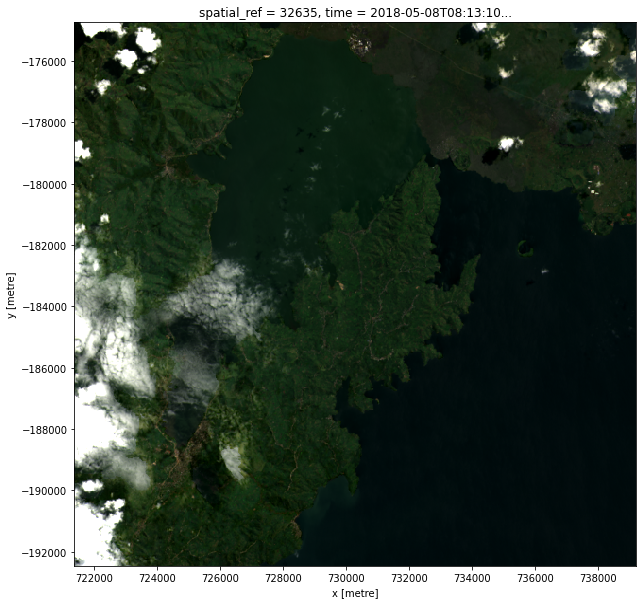

In [9]:
rgb(s6_l2_data, size=10)

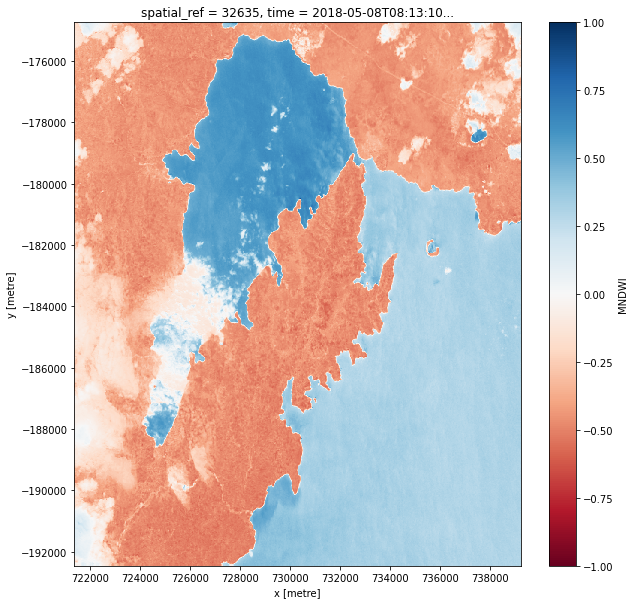

In [10]:
s6_l2_data.MNDWI.plot(figsize = (10,10), vmax=1, vmin=-1, cmap='RdBu')

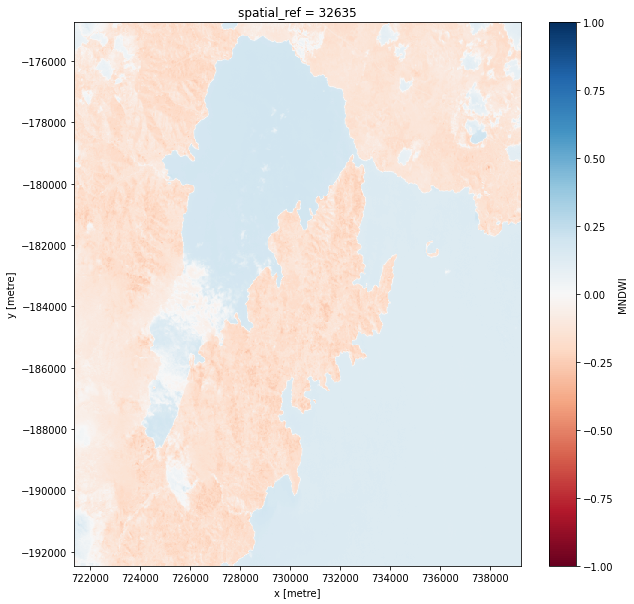

In [11]:
s6_l1_data.MNDWI.plot(figsize=(10,10), 
                      vmax=1, vmin=-1,
                      cmap='RdBu')

## Plot Rio Baboque MNDWI - 

### Shows less confusion over the waterline with default threshold
### Shows more corroboration with WOfS

In [12]:
display_map(x=gb_lon_range, y=gb_lat_range)

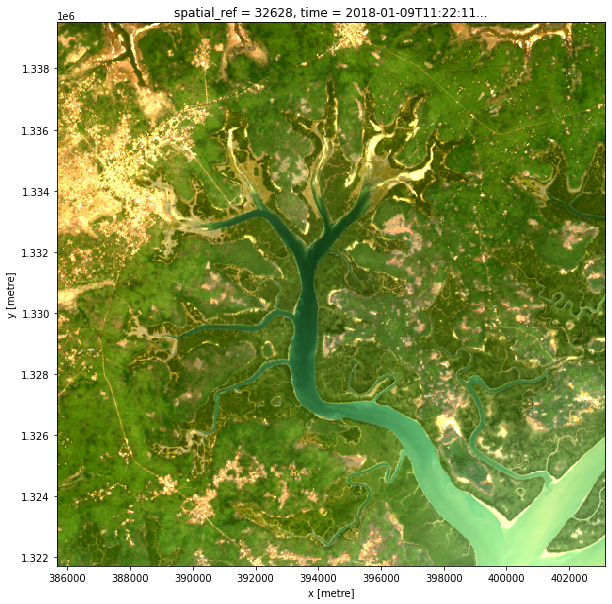

In [13]:
rgb(gb_l2_data, size=10)

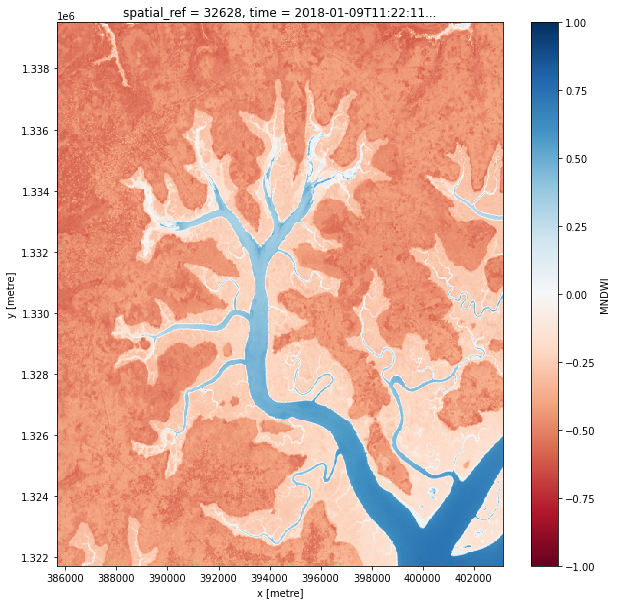

In [14]:
gb_l2_data.MNDWI.plot(figsize = (10,10), vmax=1, vmin=-1, cmap='RdBu')

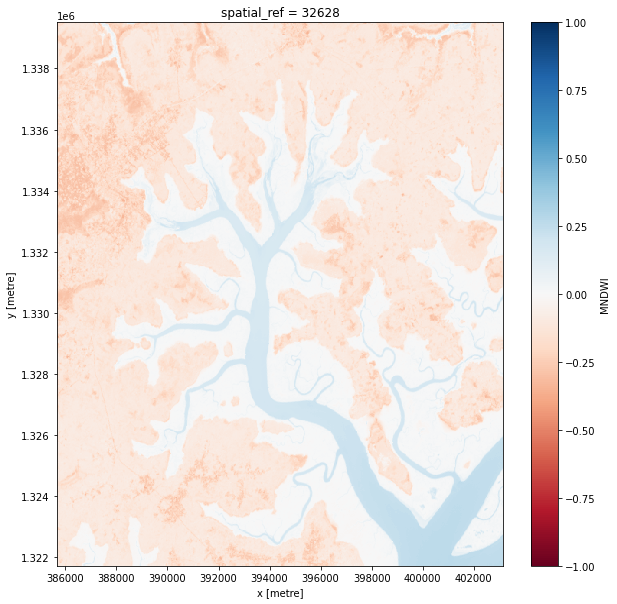

In [15]:
gb_l1_data.MNDWI.plot(figsize=(10,10), vmax=1, vmin=-1, cmap='RdBu')

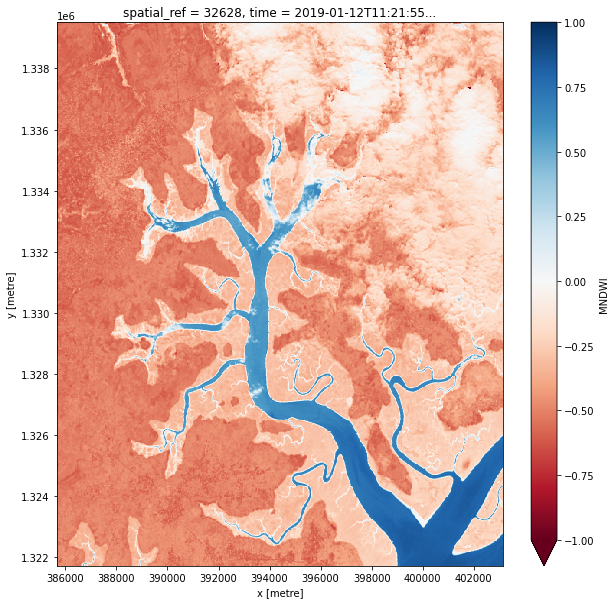

In [16]:
tr_l2_data.MNDWI.plot(figsize = (10,10), vmax=1, vmin=-1, cmap='RdBu')

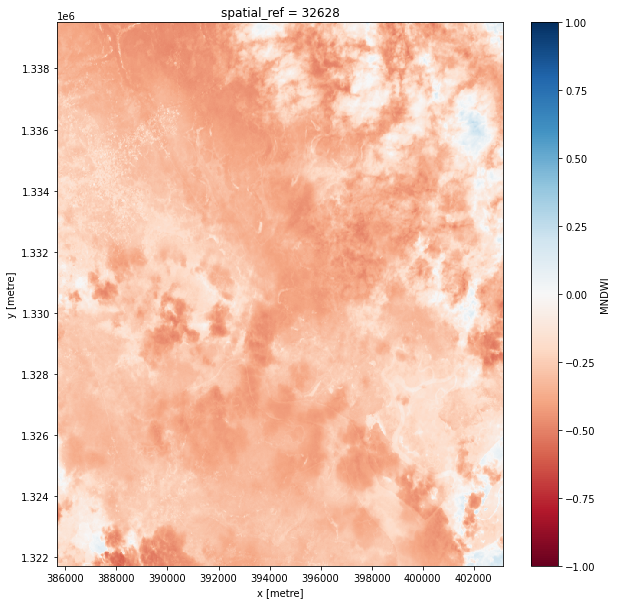

In [17]:
tr_l1_data.MNDWI.plot(figsize=(10,10), 
                      vmax=1, vmin=-1, 
                      cmap='RdBu')

## Waterlines and WOfS

In [21]:
print(wofs.water)

<xarray.DataArray 'water' (y: 593, x: 583)>
array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 128, 128, 128],
       [  0,   0,   0, ..., 128, 128, 128],
       [  0,   0,   0, ..., 128, 128, 128]], dtype=uint8)
Coordinates:
    time         datetime64[ns] 2018-01-09T11:22:11.054208
  * y            (y) float64 1.34e+06 1.339e+06 ... 1.322e+06 1.322e+06
  * x            (x) float64 3.857e+05 3.857e+05 ... 4.031e+05 4.031e+05
    spatial_ref  int32 32628
Attributes:
    units:             1
    nodata:            1
    flags_definition:  {'dry': {'bits': [7, 6, 5, 4, 3, 1, 0], 'values': {'0'...
    crs:               EPSG:32628
    grid_mapping:      spatial_ref


In [22]:
l1_contours_gdf = subpixel_contours(da=gb_l1_data.MNDWI,
                                    z_values=0,
                                    crs=gb_l2_data.crs,
                                    min_vertices=10)
l2_contours_gdf = subpixel_contours(da=gb_l2_data.MNDWI,
                                    z_values=0,
                                    crs=gb_l2_data.crs,
                                    min_vertices=10)
wofs_contours_gdf = subpixel_contours(da=wofs.water,
                                      z_values=1,
                                      crs=wofs.crs,
                                      min_vertices=10)

Operating in multiple z-value, single array mode
Operating in multiple z-value, single array mode
Operating in multiple z-value, single array mode


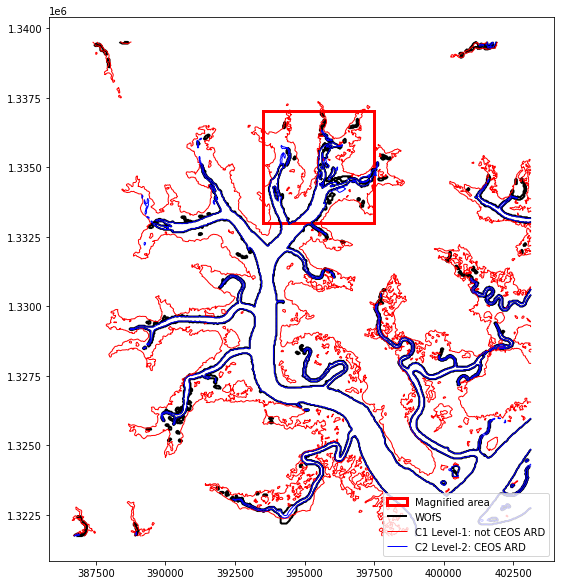

In [43]:
contour_xmin = 393500
contour_xmax = 397500
contour_ymin = 1333000
contour_ymax = 1337000

wofs_contours_gdf.plot(linewidth=2.0, color='black', figsize = (10,10))  
l1_contours_gdf.plot(ax = plt.gca(), linewidth=1.0, color='red')  
l2_contours_gdf.plot(ax = plt.gca(), linewidth=1.0, color='blue')  

selection = patches.Rectangle(
    (contour_xmin, contour_ymin),
    4000,
    4000,
    linewidth=3,
    edgecolor="red",
    facecolor="none",
)
plt.gca().add_patch(selection)

plt.legend(labels = ['Magnified area','WOfS', 'C1 Level-1: not CEOS ARD', 'C2 Level-2: CEOS ARD'], loc = 'lower right')



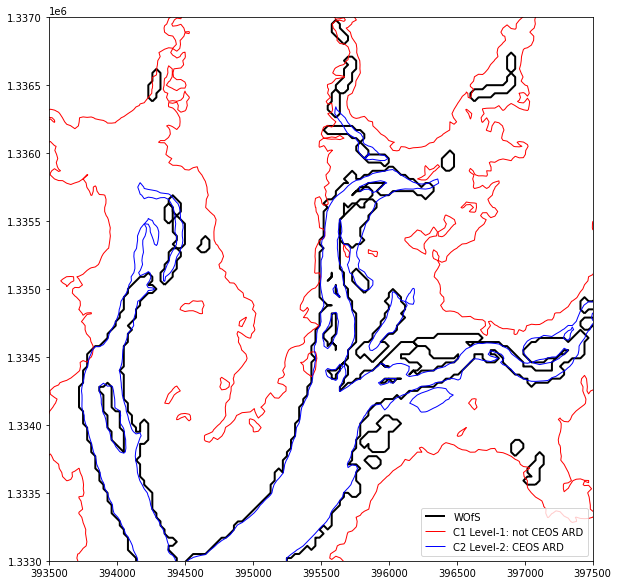

In [29]:
wofs_contours_gdf.plot(linewidth=2.0, color='black', figsize = (10,10))  
l1_contours_gdf.plot(ax = plt.gca(), linewidth=1.0, color='red')  
l2_contours_gdf.plot(ax = plt.gca(), linewidth=1.0, color='blue')  

axes = plt.gca()
axes.set_xlim([contour_xmin,contour_xmax])
axes.set_ylim([contour_ymin,contour_ymax])

plt.legend(labels = ['WOfS', 'C1 Level-1: not CEOS ARD', 'C2 Level-2: CEOS ARD'], loc = 'lower right')